# Exercise of WIC
Intelligent Embedded Systems Lab, University of Freiburg

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Contact: Lena Uhlenberg lena.uhlenberg@informatik.uni-freiburg.de

March, 2023

## Introduction
Naive Bayesian classifier (NBC) is a probabilistic machine learning algorithm based on Bayes' Theorem. NBC appears simple, but performs well even on some complex classification challenges. NBC is an appropriate introduction for learners to get a quick impression of classifiers. Your task in the exercise is to implement a NBC and use it to classify three daily activities ('Eating', 'Walking', and 'Sedentary').


## Learning objectives
1. Understand the importance of feature selection and selection principles.
2. Understand Bayes' Theorem and the assumption of Naive Bayesian method.
3. Understand basic terminology and concepts in context recognition.
4. Implement a NBC and classify daily activities.

## Procedure
1. Follow the notebook and complete the code snippets where required.
2. Answer the questions at the end of the notebook.
3. Submit the notebook after finishing the previous steps.

## Data
We use an excerpt of the dataset collected for the paper:
*Florian Wahl, Martin Freund, Oliver Amft, "WISEglass: Smart eyeglasses recognising context", EAI Endorsed Transactions on Pervasive Health and Technology, eudl.eu, 2015*. PDF at the bottom of the page: https://www.cdh.med.fau.de/publications/?id=FHX48BI6. 
The data excerpt was recorded using sensor-integrated smart eyeglasses worn by 5 participants when performing 3 daily activities. It contains 28 features extracted from accelerometer and gyroscope recordings. 

Here are the details of the feature extraction:
All features were computed in a sliding window applied to the sensor signals (multiple channels synchronized). The sliding window size was 1500 samples (30 s) and the step size was 50 samples (1 s). Features were computed over all the sensor channels, including accelerometer (channels "ax", "ay", and "az"), gyroscope (channels "gx", "gy", and "gz") and the L2 norm (Euclidean norm) for the acceleration axis "anorm". The features are standardized to have zero mean and unit variation.

For the following analysis, activity labels are grouped into three categories "Eating", "Walking", and "Sedentary". They form the three classes to be classified.
<pre>
| Label ID | Description      | Class  |
|----------+------------------+-----------|
|        1 | Breakfast        | Eating    |
|       15 | Lunch            | Eating    |
|       25 | Dinner           | Eating    |
|        6 | Walking @ 2 km/h | Walking   |
|        7 | Walking @ 5 km/h | Walking   |
|       10 | Reading          | Sedentary |
|       17 | Screen work      | Sedentary |
|       18 | Desk work        | Sedentary |
</pre>



First, load and examine the dataset and check the rows and columns. 
What are the **features**? What are the **samples** (i.e. **instances**)?

In [2]:
import pandas as pd
import numpy as np
import math
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

# Load data 
# Load data
all_df = pd.read_hdf('data/data_E3.h5', 'data')

# Add category info to data
label_category_dict = dict([(1, 1), (15, 1), (25, 1), (6, 2), (7, 2), (10, 3), (17, 3), (18, 3)])
label_category_str_dict = dict([(1, 'Eating'), (15, 'Eating'), (25, 'Eating'), (6, 'Walking'), (7, 'Walking'), (10, 'Sedentary'), (17, 'Sedentary'), (18, 'Sedentary')])
all_df['label_category'] = all_df.label.map(label_category_dict)
all_df['label_category_str'] = all_df.label.map(label_category_str_dict)

# Print data
all_df

,maccelX_mean,maccelY_mean,maccelZ_mean,mgyroX_mean,mgyroY_mean,mgyroZ_mean,maccelNorm_mean,maccelX_var,maccelY_var,maccelZ_var,...,maccelY_energy,maccelZ_energy,mgyroX_energy,mgyroY_energy,mgyroZ_energy,maccelNorm_energy,label,participant,label_category,label_category_str
0,-13133.378667,-7415.320000,-395.850667,5.024667,6.200000,-15.978000,15410.648624,1.516028e+06,5.755263e+06,2.667956e+06,...,6.073840e+07,2.822876e+06,16320.788667,12938.778667,29583.951333,2.375619e+08,1.0,2,1,Eating
1,-13007.874667,-7682.157333,-358.869333,7.191333,4.004667,-8.756667,15412.061591,1.505408e+06,5.090313e+06,2.664039e+06,...,6.410246e+07,2.791050e+06,16177.471333,13034.294000,24649.263333,2.376027e+08,1.0,2,1,Eating
2,-12906.002667,-7826.821333,-349.053333,3.112667,1.202667,-9.877333,15414.941325,1.636886e+06,5.441185e+06,2.667817e+06,...,6.669669e+07,2.787877e+06,15644.151333,12381.952000,24560.297333,2.376853e+08,1.0,2,1,Eating
3,-12816.824000,-7968.296000,-348.152000,7.327333,3.408000,-3.300667,15422.191246,1.699774e+06,5.641997e+06,2.703788e+06,...,6.913198e+07,2.823195e+06,21359.918000,13946.748000,27313.195333,2.379248e+08,1.0,2,1,Eating
4,-12855.394667,-7832.786667,-380.584000,13.038667,8.230000,3.961333,15419.660302,1.837918e+06,6.592879e+06,2.674607e+06,...,6.794103e+07,2.817668e+06,28843.077333,16063.036667,30863.672000,2.378566e+08,1.0,2,1,Eating
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42736,-4475.682667,-10913.600000,-848.034667,32.270000,-3.014667,16.198667,15875.238871,5.150524e+07,5.876971e+07,2.277925e+06,...,1.778372e+08,2.995569e+06,38318.616667,10365.056000,99706.532000,2.523354e+08,18.0,9,3,Sedentary
42737,-4954.970667,-10521.248000,-794.304000,28.883333,0.615333,5.826667,15862.542711,5.415325e+07,5.961817e+07,2.367750e+06,...,1.702751e+08,2.997090e+06,39287.370000,9941.262000,104946.830667,2.519411e+08,18.0,9,3,Sedentary
42738,-5367.013333,-10284.162667,-726.389333,25.832000,-4.498667,3.422667,15843.942226,5.515170e+07,5.873720e+07,2.452708e+06,...,1.644620e+08,2.978714e+06,39757.109333,10821.868000,105873.258667,2.513605e+08,18.0,9,3,Sedentary
42739,-5757.402667,-10097.968000,-627.642667,25.146667,-5.733333,2.374667,15827.625221,5.517717e+07,5.763974e+07,2.598419e+06,...,1.595703e+08,2.990622e+06,39806.833333,10980.894667,106266.966667,2.508490e+08,18.0,9,3,Sedentary


In [3]:
# How many participants are included in the dataset exerpt, what participant IDs
print("Total number of participants: " + str(len(set(all_df['participant']))))
print("Participant IDs: " + str(set(all_df['participant'])))

Total number of participants: 5
Participant IDs: {2, 4, 5, 8, 9}


In [4]:
# Access to any entry in the matrix. e.g.:
all_df['participant'][0]

2

In [5]:
# Which features
pprint([feature_name for feature_name in all_df.columns])

['maccelX_mean',
 'maccelY_mean',
 'maccelZ_mean',
 'mgyroX_mean',
 'mgyroY_mean',
 'mgyroZ_mean',
 'maccelNorm_mean',
 'maccelX_var',
 'maccelY_var',
 'maccelZ_var',
 'mgyroX_var',
 'mgyroY_var',
 'mgyroZ_var',
 'maccelNorm_var',
 'maccelX_max',
 'maccelY_max',
 'maccelZ_max',
 'mgyroX_max',
 'mgyroY_max',
 'mgyroZ_max',
 'maccelNorm_max',
 'maccelX_min',
 'maccelY_min',
 'maccelZ_min',
 'mgyroX_min',
 'mgyroY_min',
 'mgyroZ_min',
 'maccelNorm_min',
 'maccelX_zcr',
 'maccelY_zcr',
 'maccelZ_zcr',
 'mgyroX_zcr',
 'mgyroY_zcr',
 'mgyroZ_zcr',
 'maccelNorm_zcr',
 'maccelX_fluc',
 'maccelY_fluc',
 'maccelZ_fluc',
 'mgyroX_fluc',
 'mgyroY_fluc',
 'mgyroZ_fluc',
 'maccelNorm_fluc',
 'maccelX_beg',
 'maccelY_beg',
 'maccelZ_beg',
 'mgyroX_beg',
 'mgyroY_beg',
 'mgyroZ_beg',
 'maccelNorm_beg',
 'maccelX_end',
 'maccelY_end',
 'maccelZ_end',
 'mgyroX_end',
 'mgyroY_end',
 'mgyroZ_end',
 'maccelNorm_end',
 'maccelX_eminb',
 'maccelY_eminb',
 'maccelZ_eminb',
 'mgyroX_eminb',
 'mgyroY_eminb',
 '

## Inspect features, discuss feature relevance
The "seaborn" library can be used to visualize feature distributions.
Create scatter plots and histograms with several features. Discuss how to use the plots to narrow down the features to include? Based on your observation, which features would be useful for training a clasifier. Are there other methods to find suitable features?

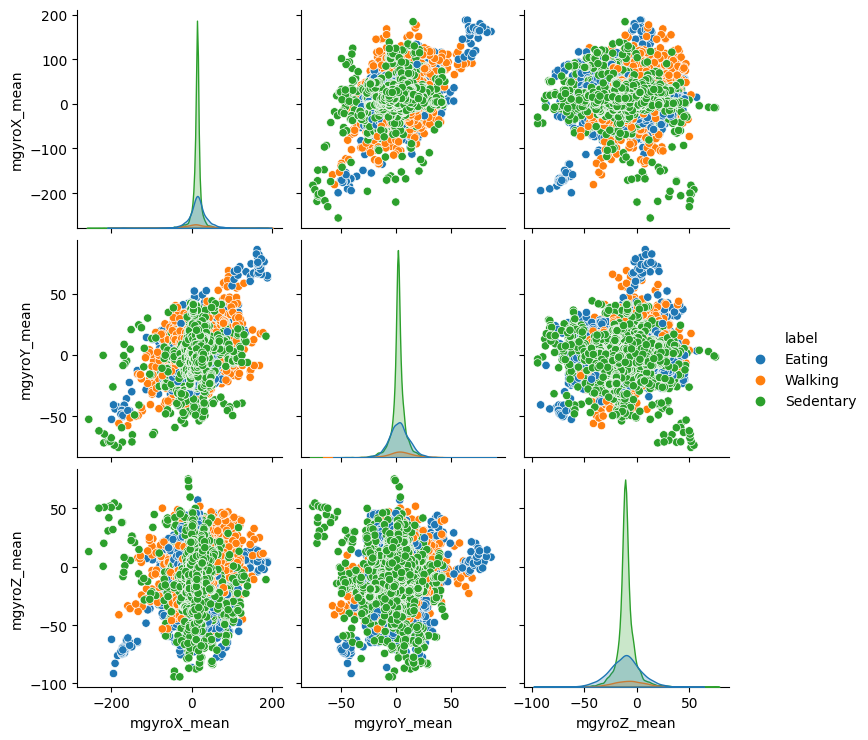

In [6]:
def select_features(columns, feature_list):
    features = []
    for feature in feature_list:
        features.extend(list(filter(lambda x: feature in x, columns)))
    return features

# 1. Find features: Toggle features here
feature_list = select_features(all_df.columns.values, [
    'mgyroX_mean',
    'mgyroY_mean',
    'mgyroZ_mean', 
])

# 2. Select features by name and insert into new feature matrix
tmp_df = all_df[feature_list].copy()

# 3. Add label (string) column
tmp_df['label'] = all_df.label_category_str

# seaborn plot method
sns.pairplot(tmp_df, hue="label")
plt.show()

Since you have seen the data, the next task becomes concrete: Given a sample, find out which class it belongs to. This is a typical **classification** challenge. There are 3 classes ("Eating", "Walking", "Sedentary"). A random guess will give you a correctness of ~33.3%. Can a NBC do a better job? Let's implement one and see.

As a recap of the Bayes' Theorem:
\begin{equation*}
P(Y|X) = \frac{P(X|Y)*P(Y)}{P(X)}
\end{equation*}

Here, you can regard $X$ as **one** feature (e.g. mgyroY_mean) and $Y$ as the class label.

The theorem can also be written as:

\begin{equation*}
posterior = \frac{conditional*prior}{evidence}
\end{equation*}

For every class, you need to build such a statistical model. When predicting the class of a new sample, you can compute the maximal posterior out of all the built models. The $conditional$ (also called likelihood) can be computed from the training samples (feature & label). The $prior$ can be computed as the ratio of the training labels. The $evidence$ is a constant number for different models and can be ignored in the NBC implementation, because you only need to know the **relative** relation of the posteriors from all models. When you have **multiple** features, you simply need to to replace the above model with joint models, we will see this later.

## Training data preparation 
One important thing is to split the data into a **training set** and a **test set**. Consider why it is necessary to split the data.

In [28]:
df_data=all_df[['maccelX_mean',
                'maccelY_mean',
                'maccelZ_mean',
                'mgyroX_mean',
                'mgyroY_mean',
                'mgyroZ_mean',
                'maccelX_fluc',
                'maccelY_fluc',
                'maccelZ_fluc',
                'mgyroX_fluc',
                'mgyroY_fluc',
                'mgyroZ_fluc',
                'mgyroZ_diff_diff_possum', 
                'maccelY_min',
                'participant', 
                'label_category',
                'label_category_str']]

# Split data
df_train = df_data.loc[df_data.participant.isin([2, 4, 5, 8])].reset_index(drop=True)  # variable will be used for training
df_test = df_data.loc[df_data.participant==9].reset_index(drop=True)                   # variable will be used for testing

## Implement a NBC
When training a NBC model, we feed the **features** and the ground truth (i.e. **class labels**) of the training samples to the NBC. The NBC models the sample distribution by calculating **parameters** (mean and variance) of every feature. This modeling work needs to be done for every class and every feature. Therefore, it is first necessary to separate the training set by class labels. This can be done using the function below.

In [29]:
def separate_class(df):
    separated = {}
    for label_category in [1, 2, 3]:
        separated[label_category] = df.loc[df.label_category == label_category]
    return separated  # samples seperated by class labels 1 (eating), 2 (walking), 3 (sedentary)

Feed the training set to the function and see what it returns:

In [30]:
separate_class(df_train)[1]  # class 1 - eating

,maccelX_mean,maccelY_mean,maccelZ_mean,mgyroX_mean,mgyroY_mean,mgyroZ_mean,maccelX_fluc,maccelY_fluc,maccelZ_fluc,mgyroX_fluc,mgyroY_fluc,mgyroZ_fluc,mgyroZ_diff_diff_possum,maccelY_min,participant,label_category,label_category_str
0,-13133.378667,-7415.320000,-395.850667,5.024667,6.200000,-15.978000,-10.666524,-3.090988,-0.242349,0.039348,0.054569,-0.093268,10.122667,-11400.0,2,1,Eating
1,-13007.874667,-7682.157333,-358.869333,7.191333,4.004667,-8.756667,-10.601792,-3.404952,-0.219870,0.056611,0.035087,-0.055843,9.804000,-11400.0,2,1,Eating
2,-12906.002667,-7826.821333,-349.053333,3.112667,1.202667,-9.877333,-10.087475,-3.355356,-0.213705,0.024885,0.010805,-0.063131,9.609333,-12072.0,2,1,Eating
3,-12816.824000,-7968.296000,-348.152000,7.327333,3.408000,-3.300667,-9.830708,-3.354664,-0.211730,0.050182,0.028860,-0.019969,9.940667,-12400.0,2,1,Eating
4,-12855.394667,-7832.786667,-380.584000,13.038667,8.230000,3.961333,-9.482490,-3.050554,-0.232713,0.076975,0.065052,0.022547,10.367333,-12400.0,2,1,Eating
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28588,-15035.680000,-1942.109333,-397.024000,-7.766667,-2.774000,-27.622667,-23.444495,-0.677409,-0.273764,-0.009798,-0.016845,-0.091978,17.762000,-8156.0,8,1,Eating
28589,-15039.522667,-1881.426667,-456.002667,-2.616000,-4.362000,-7.630667,-25.201862,-0.659528,-0.311617,-0.003317,-0.028745,-0.028018,16.980667,-8156.0,8,1,Eating
28590,-15053.269333,-1768.194667,-539.458667,-14.003333,-1.352667,-14.330000,-25.513477,-0.625096,-0.361845,-0.018262,-0.009145,-0.056435,16.082000,-6580.0,8,1,Eating
28591,-15046.034667,-1731.901333,-590.192000,-5.812667,-3.380667,-8.636000,-25.741890,-0.606693,-0.390170,-0.007483,-0.022716,-0.034240,15.894667,-6580.0,8,1,Eating


NBC is a probabilistic algorithm, which means the classifier needs to learn the distribution of the features using the training data. We can assume every feature of the training samples follows a certain distribution, e.g. Gaussian distribution. Keep in mind, NBC is not restricted to Gaussian distribution. It can work with other types of distributions as well, e.g. Bernoulli distribution, etc. However, Gaussian distribution is mostly used.

Assume the features follow Gaussian distributions. Please write a function to calculate the $conditional$ item in Bayes' theorem, which essentially is merely a Gaussian function value. 

Recap: PDF of Gaussian distribution:
\begin{equation*}
f(x)=\frac{1}{\sqrt{2\pi}\sigma}e^-\frac{(x-\mu)^2}{2\sigma^2}
\end{equation*}
where $\mu$ is the mean, and $\sigma$ is the standard deviation.

In [31]:
def Gaussian(feature, mean, std):
    # arguments:feature
    #           mean: average of feature across given samples
    #           std: standard deviation of feature across given samples
    # return: gauss: Gaussian function value
    
    # Please implement your own code below
    # gauss = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((feature - mean) / std) ** 2)
    exponent = -(feature - mean) ** 2 / (2 * std ** 2)
    gauss = np.exp(exponent) / (std * np.sqrt(2 * np.pi))
    return gauss

When you have only one feature, applying Bayes' theorem to the feature will yield a posterior which represents the "probability" that the sample belongs to a certain class. However, there are 28 features in our dataset. It is unlikely that all of them yield the same predicted class label. You need a strategy to deal with the situation when the predictions of the 28 features do not converge. 
For that purpose, you need the joint probability. You can do this using a simple operation among "+", "-", "*", and "/", but which one is the correct operation?

Please write a function to calculate the joint probability ($posterior$) of multiple features. 

Note that to simplify the computation of joint probability, you need to assume that all features are conditionally independent when the class label is given. --> Very **naive** as in the name "Naive Bayes"! Do not forget to include the $prior$ in the function, which can be regarded as the frequency of each class in the training set.

In [32]:
def calc_posterior(features, mean, std, prior):  
    # arguments: features
    #           mean: average of feature across given samples
    #           std: standard deviation of feature across given samples
    # return: posterior: i.e. the joint probability
    
    # below is an example implementation
    gauss = np.log((Gaussian(features, mean, std) + 1.e-17))  # use logrithm to avoid underflow; add a small amount to avoid log of zero
    posterior = gauss.sum(axis=1) + np.log(prior)
    
    return posterior                                    # posterior i.e. the joint probability

## Training and testing
To this point, you already completed the tools to train a NBC! Now let's train and test the classifier. A piece of code is offered below to calculate the posterior of each class. Read the code, and consider what parameters are passed to the functions? Which part of the code reflects training? Which part reflects testing? 

In [33]:
# Separate samples by class
df_classes = separate_class(df_train[df_train.columns])
df_classes[1] = df_classes[1].reset_index(drop=True)
df_classes[2] = df_classes[2].reset_index(drop=True)
df_classes[3] = df_classes[3].reset_index(drop=True)

# Compute priors
total_samples = df_classes[1].shape[0] + df_classes[2].shape[0] + df_classes[3].shape[0]
prior_1 = df_classes[1].shape[0] / total_samples
prior_2 = df_classes[2].shape[0] / total_samples
prior_3 = df_classes[3].shape[0] / total_samples

# Compute posteriors
test_samples = df_test[df_test.columns[: -3]]

posterior_class_1 = calc_posterior(test_samples, df_classes[1].mean(numeric_only=True), df_classes[1].std(numeric_only=True), prior_1)
posterior_class_2 = calc_posterior(test_samples, df_classes[2].mean(numeric_only=True), df_classes[2].std(numeric_only=True), prior_2)
posterior_class_3 = calc_posterior(test_samples, df_classes[3].mean(numeric_only=True), df_classes[3].std(numeric_only=True), prior_3)




In [34]:
# Predict the label --> maximum of the three posteriors
concat = np.vstack((posterior_class_1, posterior_class_2, posterior_class_3))
max_post_class = np.argmax(concat, axis = 0) + 1

## Evaluation
Next, we want to know how well the NBC performs. This process is called **evaluation**. We need an **evaluation metric** to represent the classifier's performance. There are many different types of evaluation metrics. For classification challenges, **accuracy** is often a good choice among many more. Accuracy measures the ratio of the correctly classified samples in the whole test set. 

Let's plot the posteriors and predicted classes. First, the posteriors.

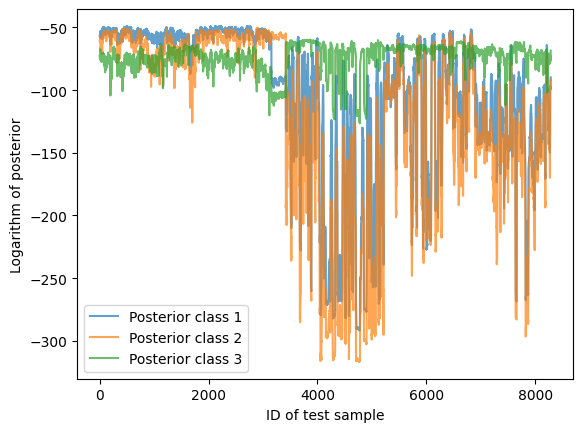

In [35]:
plt.figure()
plt.plot(posterior_class_1, label='Posterior class 1', alpha=0.7)
plt.plot(posterior_class_2, label='Posterior class 2', alpha=0.7)
plt.plot(posterior_class_3, label='Posterior class 3', alpha=0.7)
plt.xlabel('ID of test sample')
plt.ylabel('Logarithm of posterior')
plt.legend()

Then, we further plot the estimated class labels and the ground truth labels.

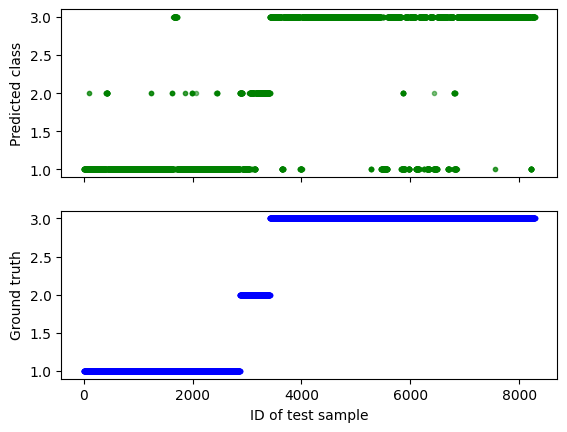

In [36]:
fig, axes = plt.subplots(2)

axes[0].plot(max_post_class, 'g.', alpha=0.5)
axes[0].set_xlabel('ID of test sample')
axes[0].set_ylabel('Predicted class')

axes[1].plot(df_test['label_category'], 'b.', alpha=0.5)
axes[1].set_xlabel('ID of test sample')
axes[1].set_ylabel('Ground truth')

for ax in axes:
    ax.label_outer()


Finally, we can calculate the accuracy.

In [37]:
true_positive = np.sum([1 for i in range(len(max_post_class)) if max_post_class[i] == df_test['label_category'][i]])
print('Classification accuracy: ' + str('%.1f' % (true_positive/len(max_post_class) * 100)) + '%')



Classification accuracy: 90.3%


If you made it to this step, you might have seen the NBC has yielded a much better accuracy than guessing (accuracy = 33.3%)! Well done! Although unlikely, in case the results were worse than guessing, do not panic. We have some techniques in the next exercises to fix the problem.

## Questions

Please answer directly in this code block.
#### 1. What is Bayes' Theorem? 
Answer: Bayes' Theorem is a concept in probability theory and statistics that allows us to update our beliefs or probabilities based on new evidence or information. Bayes' Theorem provides a framework for updating the probability of an event A in light of new evidence B. It involves multiplying the prior probability of A (P(A)) by the likelihood of B given A (P(B|A)), and dividing it by the overall probability of B (P(B)).

#### 2. What does "Naive" indicate in the name "Naive Bayesian Classifier"? 
Answer: In the context of the "Naive Bayesian Classifier," the term "naive" indicates a simplifying assumption made by the classifier regarding the independence of the features or variables involved. It assumes that the presence or absence of a particular feature in a class is independent of the presence or absence of any other feature.

#### 3. Please describe the work steps needed to train an NBC in an application-independent form. Assume that the training set is provided.
Answer: 
To train a Naive Bayesian Classifier (NBC) in an application-independent manner, follow these steps:

1. **Data Preprocessing:**
   - Obtain a labeled training dataset.
   - Clean the dataset by removing irrelevant data and handling missing values.

2. **Feature Extraction:**
   - Identify relevant features for classification.
   - Extract or select appropriate features from the dataset.

3. **Class Probability Estimation:**
   - Calculate the prior probabilities of each class.

4. **Feature Probability Estimation:**
   - Calculate conditional probabilities of each feature given each class.

5. **Model Training:**
   - Construct the NBC model using class probabilities and feature likelihoods.

6. **Model Evaluation (Optional):**
   - Assess the performance of the trained NBC using evaluation metrics.

7. **Model Deployment:**
   - Apply the trained NBC model to classify new instances.


#### 4. Name three evaluation metrics for classifiers and elaborate when to use them. 
Answer: 
When assessing the performance of classifiers, several evaluation metrics can provide valuable insights. Here are three commonly used metrics and when to use them:

1. **Accuracy:**
   - Definition: Accuracy measures the overall correctness of the classifier by calculating the ratio of correctly classified instances to the total number of instances.
   - Use: Accuracy is suitable when the class distribution in the dataset is relatively balanced and there is no significant cost associated with misclassifications across different classes.

2. **Precision:**
   - Definition: Precision represents the proportion of correctly classified positive instances out of all instances predicted as positive by the classifier.
   - Use: Precision is valuable when the focus is on minimizing false positives, such as in medical diagnosis or spam detection. It helps identify cases where precise positive predictions are crucial.

3. **Recall (Sensitivity or True Positive Rate):**
   - Definition: Recall measures the proportion of correctly classified positive instances out of all actual positive instances in the dataset.
   - Use: Recall is important when the emphasis is on minimizing false negatives, such as in disease detection or fault diagnosis. It helps identify cases where detecting all positive instances is critical.


## Submission
Make sure all coding tasks are completed, code blocks are executed, and all questions are answered.<br>
Enter your name(s) and matriculation number(s) here:<br>
**Name(s)**: Sanskar Biswal, Sidharth Suresh <br> 
**Matriculation number(s)**: 5585853,             <br>